In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats import norm, kurtosis, normaltest, probplot

from statsmodels.stats.diagnostic import kstest_normal, normal_ad, kstest_fit
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot

import arch

from preprocess import Gaussianize
from metrics import emd_score, acf_score, le_score

from tqdm import tqdm


In [2]:
#raw_data = yf.download('^GSPC','2009-05-01','2018-12-31')
raw_data = pd.read_csv('../data/BTCUSD_1m_2015_01_01_now.csv')
raw_data['Timestamp'] = pd.to_datetime(raw_data['Timestamp'])
raw_data = raw_data.set_index('Timestamp')
logret = np.log(raw_data['Close']).diff().resample('D').sum()
print(logret)
logret = logret.to_numpy()

Timestamp
2015-01-01   -0.022653
2015-01-02    0.005117
2015-01-03   -0.111998
2015-01-04   -0.065958
2015-01-05    0.047346
                ...   
2022-01-08    0.003220
2022-01-09    0.004166
2022-01-10   -0.000215
2022-01-11    0.021156
2022-01-12    0.023681
Freq: D, Name: Close, Length: 2569, dtype: float64


In [3]:
df = pd.read_csv('../data/raw_data.csv')
logret = np.log(df['Close']).diff().dropna()
logret

1       0.033307
2      -0.003799
3       0.017255
4      -0.013290
5       0.023784
          ...   
2428   -0.020803
2429   -0.027487
2430    0.048403
2431    0.008526
2432   -0.001242
Name: Close, Length: 2432, dtype: float64

In [4]:
gauss = Gaussianize()
gauss.fit(logret)
u = gauss.transform(logret)

h:\My Drive\EPFL Account\ml4f\ml4f_project\src\preprocess.py:25: RuntimeWarning: invalid value encountered in true_divide
  return np.sign(z) * np.sqrt(np.real(lambertw(delta * z ** 2)) / delta)


3.9616723034773656e-07 6


C:\Users\Luka\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 720x432 with 0 Axes>

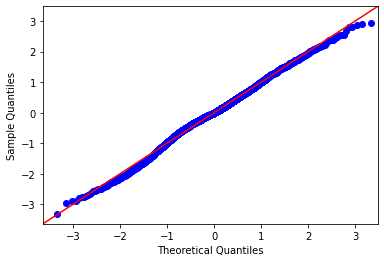

In [5]:
plt.figure(figsize=(10, 6))
qqplot(u, fit=True, line='45')
plt.show()

loc: 0.000000, scale: 1.000000
kurtosis: 3.000075
NormaltestResult(statistic=8.398756407809085, pvalue=0.015004903911067556)
(0.036168733261441544, 0.0009999999999998899)
(3.397094510220086, 1.6975077877662952e-08)


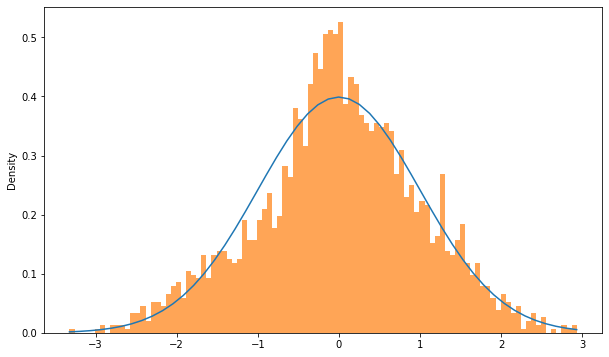

In [6]:
adfuller(u, regresults=True)

loc, scale = norm.fit(u)
print(f'loc: {loc:.6f}, scale: {scale:.6f}')
print(f'kurtosis: {kurtosis(u, fisher=False):.6f}')
print(normaltest(u))
print(kstest_normal(u))
print(normal_ad(u))
xmin, xmax = u.min(), u.max()
x = np.linspace(xmin, xmax)


plt.figure(figsize=(10, 6))
plt.plot(x, norm.pdf(x, loc, scale), label='theo')
plt.hist(u, alpha=0.7, bins=100, density=True)
plt.ylabel('Density')
plt.show()

Wall time: 0 ns
mu          0.215068
omega       3.389124
alpha[1]    0.118357
beta[1]     0.847245
Name: params, dtype: float64


100%|██████████| 2431/2431 [00:22<00:00, 106.77it/s]


(500, 2432)
loc: 0.027318, scale: 1.200086
kurtosis: 22.328628
kurtosis: 3.000075
NormaltestResult(statistic=972.7262338535688, pvalue=5.959119813981408e-212)


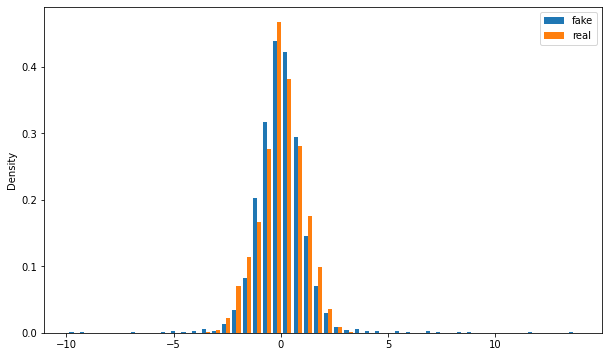

In [35]:
%time
scaling = 10
am = arch.arch_model(scaling*u)
res = am.fit(disp='off')
print(res.params)



#mu = 0
mu = res.params['mu']
omega = res.params['omega']
alpha = res.params['alpha[1]']
beta = res.params['beta[1]']

S= 250
M = 500

noise = norm.rvs(size=(logret.shape[0], M))

sigma = np.zeros(M)[:, np.newaxis]
epsilon = np.array([])
epsilon = np.append(epsilon, noise[0] * sigma[:, -1])[:, np.newaxis]
fake = (mu + epsilon[:, -1])[:, np.newaxis]



for innovation in tqdm(noise[1:]):
     sigma = np.column_stack([sigma, np.sqrt((omega + alpha * epsilon[:, -1] ** 2 + beta * sigma[:, -1] ** 2))])
     epsilon = np.column_stack([epsilon, innovation * sigma[:, -1]])
     fake = np.column_stack([fake, mu + epsilon[:, -1]])


print(fake.shape)
fake = np.array(fake) / scaling

loc, scale = norm.fit(fake[0, :])
print(f'loc: {loc:.6f}, scale: {scale:.6f}')
print(f'kurtosis: {kurtosis(fake[0, :], fisher=False):.6f}')
print(f'kurtosis: {kurtosis(u, fisher=False):.6f}')
print(normaltest(fake[0, :]))
plt.figure(figsize=(10, 6))
plt.ylabel('Density')
plt.hist([fake[0, :], u], bins=50, label=['fake', 'real'], density=True)
plt.legend()
plt.show()

In [41]:
# # fake_ret = gauss.inverse_transform(fake)
# emd = emd_score(logret, fake_ret)
acf = acf_score(logret, fake_ret, S, np.abs)
le = le_score(logret, fake_ret, S)

print(f'Earth mover Distance: {emd:.4f} \nACF Score: {acf:.4f} \nLeverage effect Score: {le:.4f}')

Earth mover Distance: 0.0009 
ACF Score: 0.7820 
Leverage effect Score: 0.4673


In [13]:
noise = norm.rvs(size=(500, logret.shape[0]))
noise[:, -1].shape

(500,)